In [1]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import csv
import datetime
import gsw
import glob
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
#import matplotlib.colormaps as cmaps
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mpl_toolkits.axes_grid1.inset_locator as inset_axes
import numpy.ma as ma
import numpy as np
from numpy import linspace
import os
import pandas as pd
#import rasterio.plot
import scipy.io
from scipy.interpolate import griddata
#import seaborn as sns
import seawater
import seawater.eos80 as sw
import xarray as xr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import unary_union


mpl.style.use('seaborn-muted')
#mpl.rc('font', family ='Arial')

/tmp/ipykernel_2052633/576144183.py:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [ ]:
### to get the data in the right format, first need to get them in the format:
# pressure | temperature | salinity | oxygen | latitude | longitude 

#then run matlab code organising_IN2021_transect.m file to calculate cons temp, abs salt etc 

## then open the files & manually add in a time column where Jan 1 = 1 & Dec 30 = 365

In [2]:
#IN2021 65E transect
name = 'IN2021'
folder_path = '../Data/Final/transect_data/IN2021_65E'
# excluded_folder = 'Transect data\IN2021_transect_65E_files\rest of transect to be edited'

# #AA1992 68E transect
# name = 'AA1992'
# folder_path = '../Data/Final/transect_data/AA1992_68E'
# excluded_folder = 'Transect data\AA1992_transect_68E_files\rest of transect to be edited'

# #IN2021 70E transect
# name = 'IN2021'
# folder_path = '../Data/Final/transect_data/IN2021_70E'
# excluded_folder = 'Transect data\IN2021_transect_70E_files\rest of transect to be edited'


In [3]:
# Initialize lists to store the extracted data
all_temp = []
all_cons_temp = []
all_salt = []
all_abs_salt = []
all_oxygen = []
all_lat = []
all_lon = []
all_depth = []
all_neu_dens = []
all_time = []


# Get a list of all CSV files in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Iterate through each file
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    
    # # Check if the file is within the excluded folder
    # if excluded_folder in file_path:
    #     continue  # Skip this file and continue to the next one
    
    # Read the CSV file into a pandas DataFrame
    data = pd.read_csv(file_path)
    
    # Extract the required columns
    temp = data['temperature']
    cons_temp = data['conservative temperature']
    salt = data['salinity']
    abs_salt = data['absolute salinity']
    oxygen = data['oxygen']
    lat = data['latitude']
    lon = data['longitude']
    depth = data['depth']
    neu_dens = data['neutral density']
    time = data['time']


    # Accumulate the extracted data
    all_temp.extend(temp)
    all_cons_temp.extend(cons_temp)
    all_salt.extend(salt)
    all_abs_salt.extend(abs_salt)
    all_oxygen.extend(oxygen)
    all_lat.extend(lat)
    all_lon.extend(lon)
    all_depth.extend(depth)
    all_neu_dens.extend(neu_dens)
    all_time.extend(time)

len(all_temp)
# print(time)



# Convert all_lat and all_depth to NumPy arrays
all_temp = np.array(all_temp)
all_cons_temp = np.array(all_cons_temp)
all_salt = np.array(all_salt)
all_abs_salt = np.array(all_abs_salt)
all_oxygen = np.array(all_oxygen)
all_lat = np.array(all_lat)
all_lon = np.array(all_lon)
all_depth = np.array(all_depth)
all_neu_dens = np.array(all_neu_dens)
all_time = np.array(all_time)

print(all_lat)
print(all_cons_temp)
len(all_lat)
len(all_cons_temp)

[-65.00009918 -65.00009918 -65.00009155 ... -66.40090179 -66.40090942
 -66.40090179]
[-0.53066383 -0.53582063 -0.53411485 ... -0.46256664 -0.46257488
 -0.46272778]


27245

In [16]:
# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry_data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')


# Extract the bathymetry data for the longitude line of 68°E
# longitude_line = 65
# longitude_line = 68
longitude_line = 70 

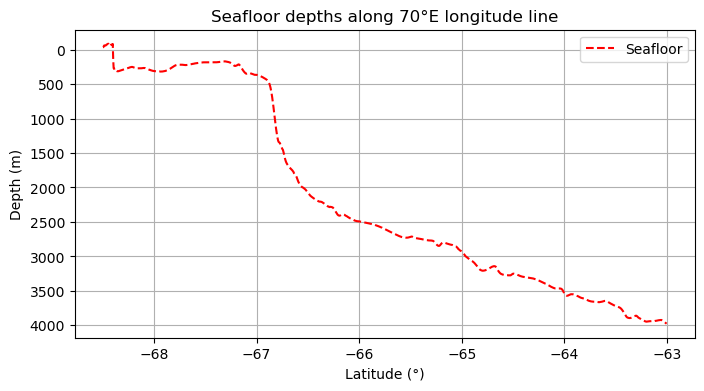

In [17]:
bathymetry_along_transect = gebco_full.sel(lon=longitude_line, method='nearest')


# Extract latitude and depth values
latitude_values = bathymetry_along_transect['lat'].values
depth_values = -bathymetry_along_transect['elevation'].values  # Negative values because bathymetry is negative


# Now, you have the latitude and seafloor depth values along the 68°E longitude line.

# Plot the seafloor depths along the 68°E longitude line
plt.figure(figsize=(8, 4))
plt.plot(latitude_values, depth_values, color='red', linestyle='--', label='Seafloor')
plt.xlabel('Latitude (°)')
plt.ylabel('Depth (m)')
plt.title(f'Seafloor depths along {longitude_line}°E longitude line')
plt.legend()
plt.grid()
# Invert the y-axis
plt.gca().invert_yaxis()
plt.show()

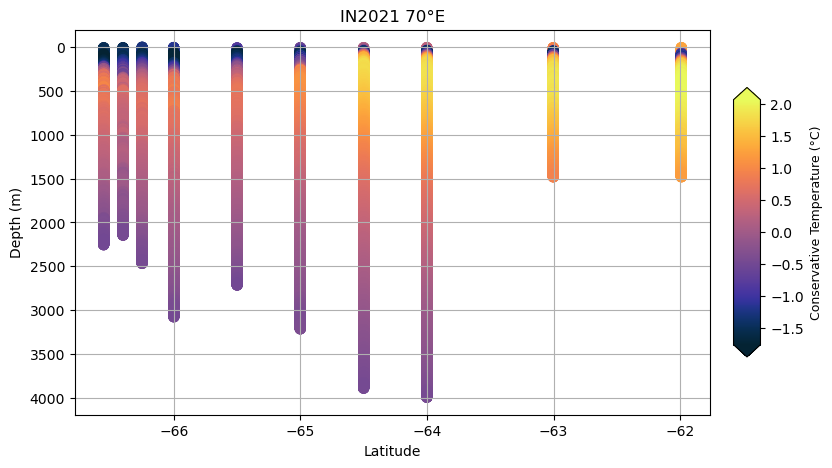

In [21]:
# visualise where the casts are along the transect

plt.figure(figsize=(10, 5))

# Create the cross-sectional transect plot
scatter = plt.scatter(all_lat, all_depth, c=all_cons_temp, cmap='cmo.thermal', s=50)

# Set the plot parameters
cbar = plt.colorbar(scatter, orientation='vertical', shrink=0.7, pad=0.03, aspect=10, extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=9)

plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title(f'{name} {longitude_line}°E')

# Reverse the y-axis to have 0m at the top
plt.gca().invert_yaxis()

# # Set the tick marks for latitude
#lat_ticks = np.arange(np.floor(np.min(lat)), np.ceil(np.max(lat)) + 0.1, 0.1)
#plt.xticks(lat_ticks, rotation='vertical')

plt.grid()


# Show the plot
plt.show()

In [18]:
# Prepare the grid of X, Z values for interpolation
X, Z = np.meshgrid(all_lat, all_depth)

# Define the grid points for interpolation
grid_lon = np.linspace(all_lat.min(), all_lat.max(), 300)
grid_depth = np.linspace(all_depth.min(), all_depth.max(), 300)
grid_X, grid_Z = np.meshgrid(grid_lon, grid_depth)


# Perform the interpolation using griddata
grid_cons_temp = griddata((all_lat, all_depth), all_cons_temp, (grid_X, grid_Z), method='linear')
grid_neu_dens = griddata((all_lat, all_depth), all_neu_dens, (grid_X, grid_Z), method='linear')
grid_abs_salt = griddata((all_lat, all_depth), all_abs_salt, (grid_X, grid_Z), method='linear')

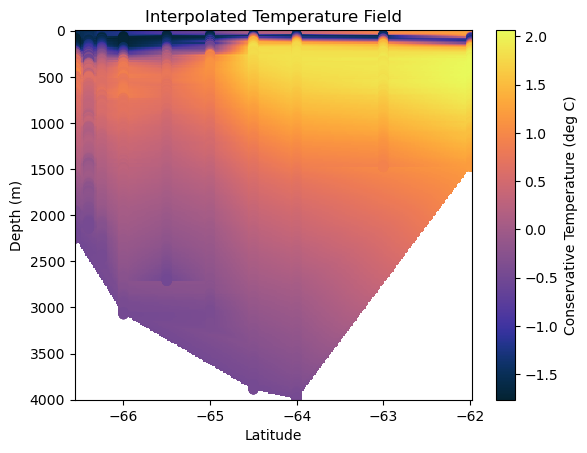

In [22]:
# Plot the interpolated field using pcolormesh
plt.pcolormesh(grid_X, grid_Z, grid_cons_temp, cmap='cmo.thermal')

# Overlay scatter/plot values
plt.scatter(all_lat, all_depth, c=all_cons_temp, cmap='cmo.thermal')

# Add colorbar
plt.colorbar(label='Conservative Temperature (deg C)')

# Set labels and title
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Interpolated Temperature Field')

# Reverse the y-axis to have 0m at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [23]:
## i was trying to crop the data so it doesn't plot beneath the sea floor but didn't seem to work properly 

# Interpolate the sea floor values to the grid's shape
sea_floor_interpolated = np.interp(grid_lon, latitude_values, depth_values)

# Create a mask for data below the sea floor
sea_floor_mask = grid_Z >= sea_floor_interpolated[:, np.newaxis]

# Apply the sea floor mask to the interpolated data
grid_cons_temp_masked = np.ma.masked_where(sea_floor_mask, grid_cons_temp)
grid_neu_dens_masked = np.ma.masked_where(sea_floor_mask, grid_neu_dens)
grid_abs_salt_masked = np.ma.masked_where(sea_floor_mask, grid_abs_salt)

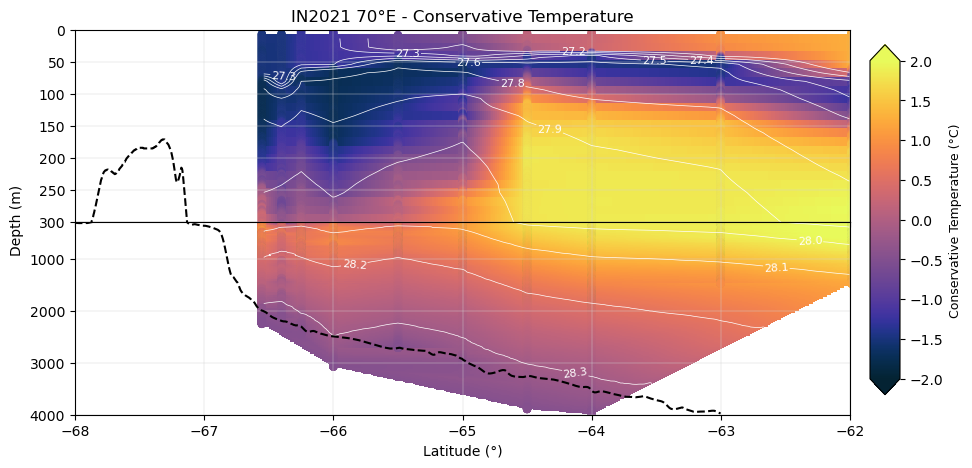

In [24]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_cons_temp, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# Overlay scatter/plot values
scat1 = ax1.scatter(all_lat, all_depth, c=all_cons_temp, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.01, vmin=-2, vmax=2)
ax1.clabel(cont1, inline=True, fontsize=8, fmt='%1.1f')
ax1.set_ylim(0, 300)
ax1.set_xlim(-68, -62)
ax1.set_title(f'{name} {longitude_line}°E - Conservative Temperature')
ax1.invert_yaxis()
ax1.set_xticklabels([])
ax1.grid(linewidth=0.3, color='lightgray')
# Plot a line for seafloor depths on both subplots
ax1.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_cons_temp, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# Overlay scatter/plot values
scat2 = ax2.scatter(all_lat, all_depth, c=all_cons_temp, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.001, vmin=-2, vmax=2)
ax2.clabel(cont2, inline=True, fontsize=8, fmt='%1.1f')
ax2.set_ylim(300, 4000)
ax2.set_xlim(-68, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
ax2.grid(linewidth=0.3, color='lightgray')
ax2.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.thermal')
norm = colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  



# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=9)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

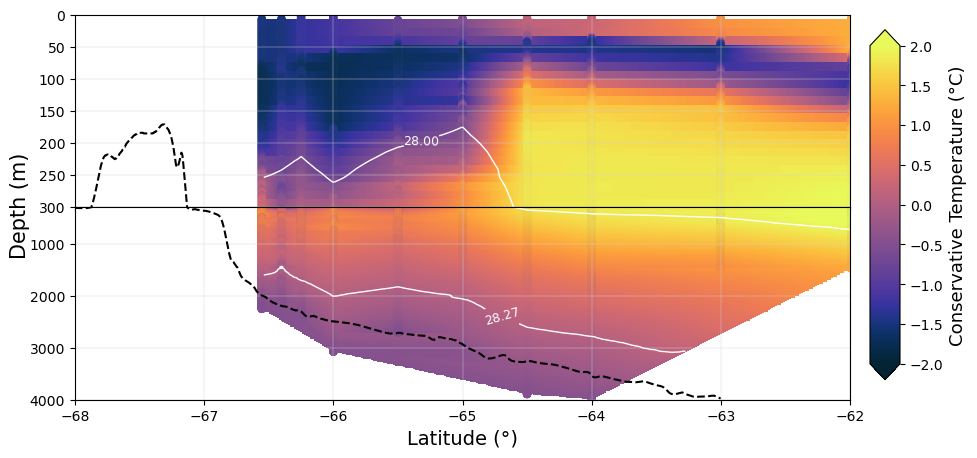

In [25]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_cons_temp, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[28, 28.27], colors='w', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(all_lat, all_depth, c=all_cons_temp, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.01, vmin=-2, vmax=2)
ax1.clabel(cont1, inline=True, fontsize=9, fmt='%1.2f')
ax1.set_ylim(0, 300)
ax1.set_xlim(-68, -62)
# ax1.set_title(f'{name} {longitude_line}°E - Conservative Temperature')
ax1.invert_yaxis()
ax1.set_xticklabels([])
ax1.grid(linewidth=0.3, color='lightgray')
# Plot a line for seafloor depths on both subplots
ax1.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_cons_temp, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[28, 28.27], colors='w', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(all_lat, all_depth, c=all_cons_temp, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.001, vmin=-2, vmax=2)
ax2.clabel(cont2, inline=True, fontsize=9, fmt='%1.2f')
ax2.set_ylim(300, 4000)
ax2.set_xlim(-68, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=14)
ax2.grid(linewidth=0.3, color='lightgray')
ax2.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.thermal')
norm = colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  


# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=13)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=15)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

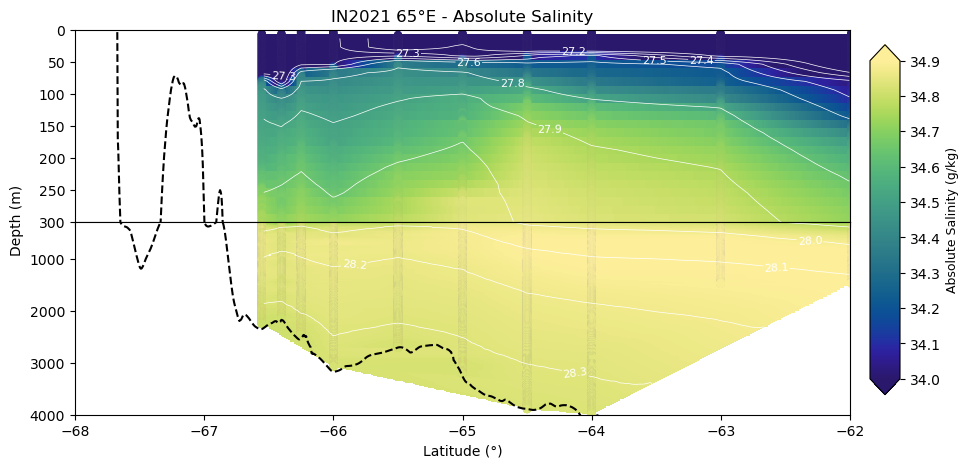

In [103]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_abs_salt, cmap='cmo.haline', vmin=34, vmax=34.9)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# Overlay scatter/plot values
scat1 = ax1.scatter(all_lat, all_depth, c=all_abs_salt, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.01, vmin=34, vmax=34.9)
ax1.clabel(cont1, inline=True, fontsize=8, fmt='%1.1f')
ax1.set_ylim(0, 300)
ax1.set_xlim(-68, -62)
ax1.set_title(f'{name} {longitude_line}°E - Absolute Salinity')
ax1.invert_yaxis()
ax1.set_xticklabels([])
ax1.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')
# ax1.grid()

# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_abs_salt, cmap='cmo.haline', vmin=34, vmax=34.9)
# cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# Overlay scatter/plot values
scat2 = ax2.scatter(all_lat, all_depth, c=all_abs_salt, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.001, vmin=34, vmax=34.9)
ax2.clabel(cont2, inline=True, fontsize=8, fmt='%1.1f')
ax2.set_ylim(300, 4000)
ax2.set_xlim(-68, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
ax2.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')
# ax2.grid()


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.haline')
norm = colors.Normalize(vmin=34, vmax=34.9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  



# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
# cbar.set_label('Conservative Temperature (°C)', fontsize=9)
cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

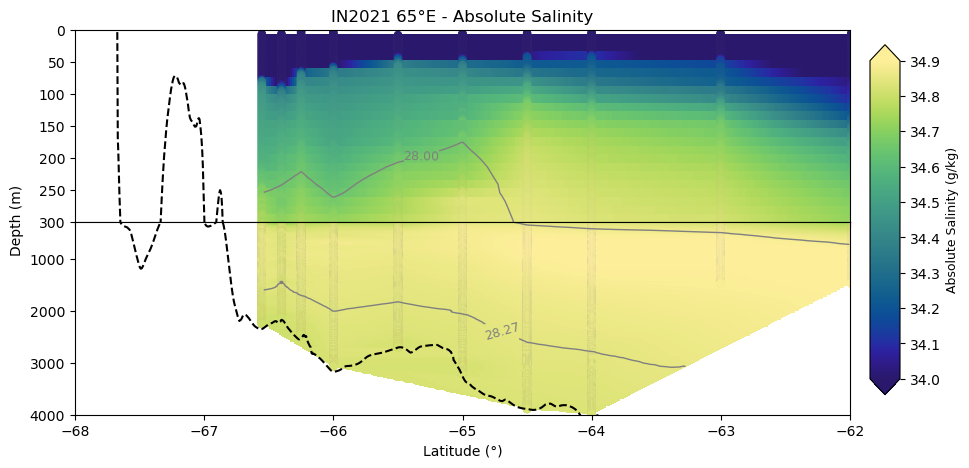

In [104]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_abs_salt, cmap='cmo.haline', vmin=34, vmax=34.9)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[28, 28.27], colors='grey', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(all_lat, all_depth, c=all_abs_salt, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.01, vmin=34, vmax=34.9)
ax1.clabel(cont1, inline=True, fontsize=9, fmt='%1.2f')
ax1.set_ylim(0, 300)
ax1.set_xlim(-68, -62)
ax1.set_title(f'{name} {longitude_line}°E - Absolute Salinity')
ax1.invert_yaxis()
ax1.set_xticklabels([])
ax1.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')
# ax1.grid()

# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_abs_salt, cmap='cmo.haline', vmin=34, vmax=34.9)
# cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
# cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[28, 28.27], colors='grey', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(all_lat, all_depth, c=all_abs_salt, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.001, vmin=34, vmax=34.9)
ax2.clabel(cont2, inline=True, fontsize=9, fmt='%1.2f')
ax2.set_ylim(300, 4000)
ax2.set_xlim(-68, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
ax2.plot(latitude_values, depth_values, color='black', linestyle='--', label='Seafloor')
# ax2.grid()


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.haline')
norm = colors.Normalize(vmin=34, vmax=34.9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  


# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
# cbar.set_label('Conservative Temperature (°C)', fontsize=9)
cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

In [105]:
# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry_data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')


# Extract the bathymetry data for the longitude line of 68°E
longitude_line = 65
# longitude_line = 68
# longitude_line = 70 

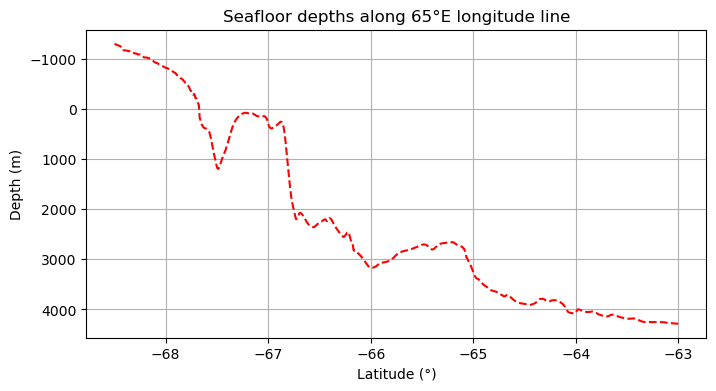

In [106]:
bathymetry_along_transect = gebco_full.sel(lon=longitude_line, method='nearest')


# Extract latitude and depth values
latitude_values = bathymetry_along_transect['lat'].values
depth_values = -bathymetry_along_transect['elevation'].values  # Negative values because bathymetry is negative


# Now, you have the latitude and seafloor depth values along the 68°E longitude line.

# Plot the seafloor depths along the 68°E longitude line
plt.figure(figsize=(8, 4))
plt.plot(latitude_values, depth_values, color='red', linestyle='--', label='Seafloor')
plt.xlabel('Latitude (°)')
plt.ylabel('Depth (m)')
plt.title(f'Seafloor depths along {longitude_line}°E longitude line')
# plt.legend()
plt.grid()
# Invert the y-axis
plt.gca().invert_yaxis()
plt.show()